## Concrete Strength Prediction 

Objective is to predict the concrete strength using the data available in file concrete_data.xls. Apply
feature engineering and model tuning to obtain 80% to 95% of R2score.

Resources Available
The data for this project is available in file 
https://archive.ics.uci.edu/ml/machine-learningdatabases/concrete/compressive/. 

From the readme file: The concrete compressive strength is the regression problem.
Also, The concrete compressive strength is a highly nonlinear function of age and 
ingredients. These ingredients include cement, blast furnace slag, fly ash, water, 
superplasticizer, coarse aggregate, and fine aggregate.


### Import the libraries and the data:

In [47]:
import warnings
warnings.filterwarnings('ignore')

In [48]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display
#plt.style.use('ggplot')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option("display.max_columns", 90)


In [49]:
# Import the data
df = pd.read_csv("concrete.csv")
display(df.head(3))

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.30,212.00,0.00,203.50,0.00,971.80,748.50,28,29.89
1,168.90,42.20,124.30,158.30,10.80,"1,080.80",796.20,14,23.51
2,250.00,0.00,95.70,187.40,5.50,956.90,861.20,28,29.22


### Exploratory Data Analysis
### Univariate

In [50]:
print('Shape:', df.shape)
display(df.describe().transpose())
display(df.info())

Shape: (1030, 9)


,count,mean,std,min,25%,50%,75%,max
cement,"1,030.00",281.17,104.51,102.00,192.38,272.90,350.00,540.00
slag,"1,030.00",73.90,86.28,0.00,0.00,22.00,142.95,359.40
ash,"1,030.00",54.19,64.00,0.00,0.00,0.00,118.30,200.10
water,"1,030.00",181.57,21.35,121.80,164.90,185.00,192.00,247.00
superplastic,"1,030.00",6.20,5.97,0.00,0.00,6.40,10.20,32.20
coarseagg,"1,030.00",972.92,77.75,801.00,932.00,968.00,"1,029.40","1,145.00"
fineagg,"1,030.00",773.58,80.18,594.00,730.95,779.50,824.00,992.60
age,"1,030.00",45.66,63.17,1.00,7.00,28.00,56.00,365.00
strength,"1,030.00",35.82,16.71,2.33,23.71,34.45,46.14,82.60


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


None

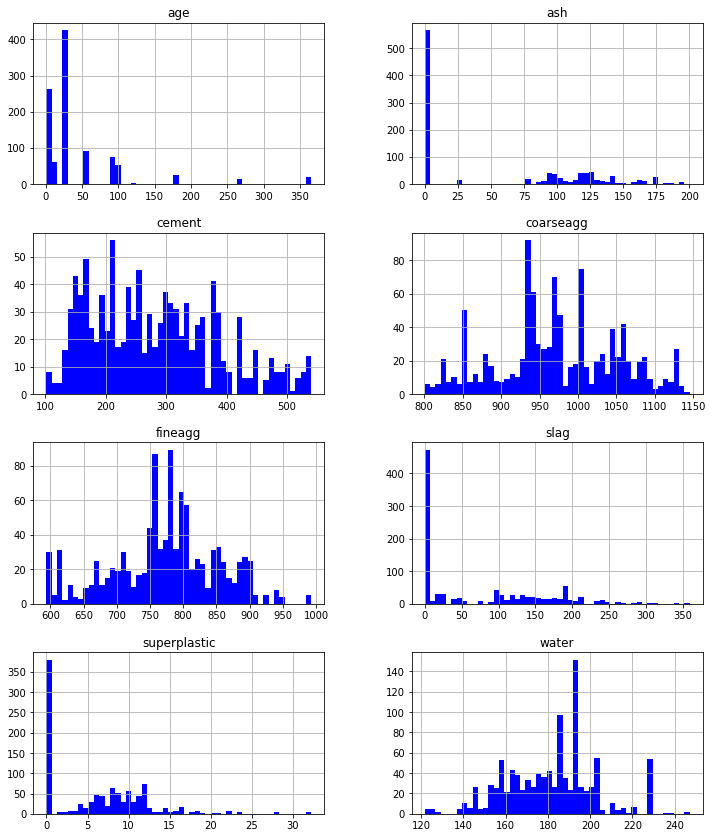

In [51]:
# Univariate plots for all input features:
columns = list(df)[0:-1] # will plot taget variable separately
df[columns].hist(stacked=False, bins=50,color = "blue", label="mean",figsize=(12,30), layout=(8,2)); 


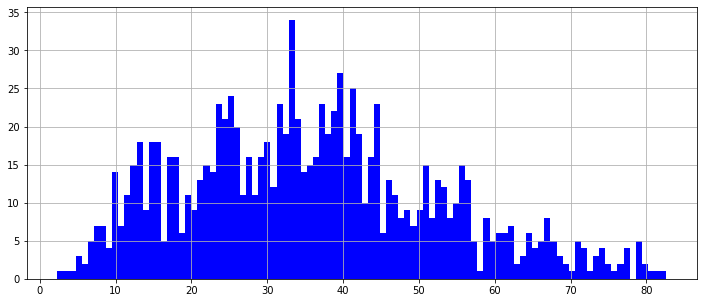

In [52]:
# A closer look at the Age variable:
df['strength'].hist(bins=100, figsize=(12,5), color='b')

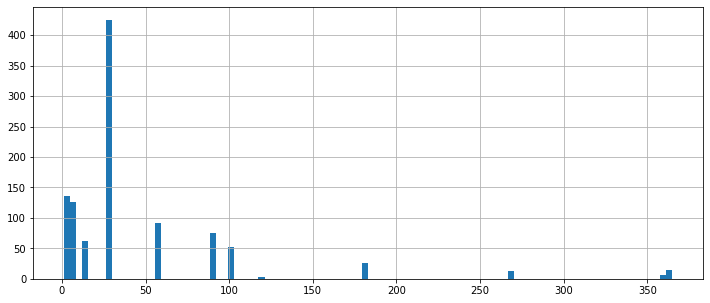

In [53]:
# A closer look at the Age variable:
df['age'].hist(bins=100, figsize=(12,5))

It appears that 'age' has discrete values, we could treat it as such or reduce outliers...

In [54]:
# discrete values of 'age':
print(df.age.value_counts())
# The predominant value (40+% is 28 )

28     425
3      134
7      126
56      91
14      62
90      54
100     52
180     26
91      22
365     14
270     13
360      6
120      3
1        2
Name: age, dtype: int64


I read in (Ref.1) that the age is a true predictor of the strength, so I will keep it, but will treat the outliers

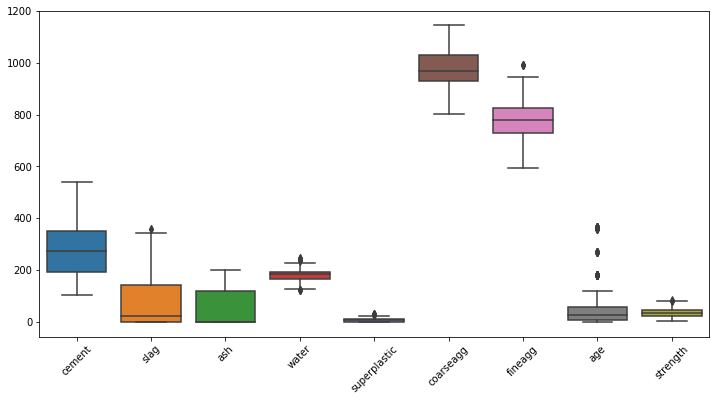

In [55]:
# Create a list with features for plotting boxplots to take a look at outliers:
plt.subplots(figsize=(12, 6))
ax = sns.boxplot(data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45);

Notes from Univariate analysis:
- All the variables in the dataset are numerical, however, 'age' seems more as a categorical variable and has outliers, max value is way higher than Q3. 
- There are no null values
- 'Slag', 'Water', 'superplastic', 'fineagg' have some outliers, will treat them
- Most input variables share same units (kg/m3), except 'age' (days) but have different scales. We need to use an scaler  to avoid bias.


### Bi-variate Analysis

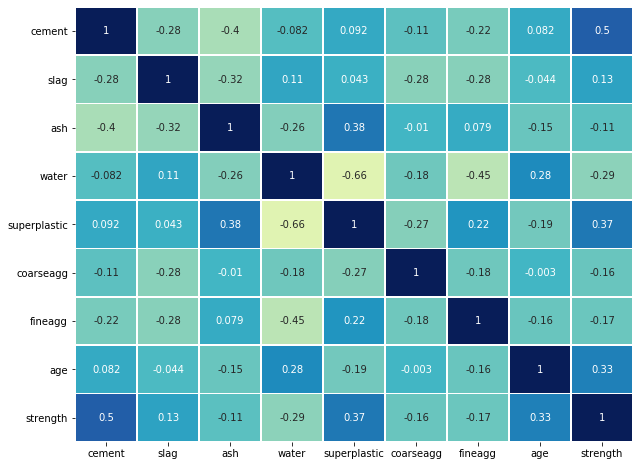

In [56]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(),
            annot=True,
            linewidths=.5,
            center=0,
            cbar=False,
            cmap="YlGnBu")
plt.show()

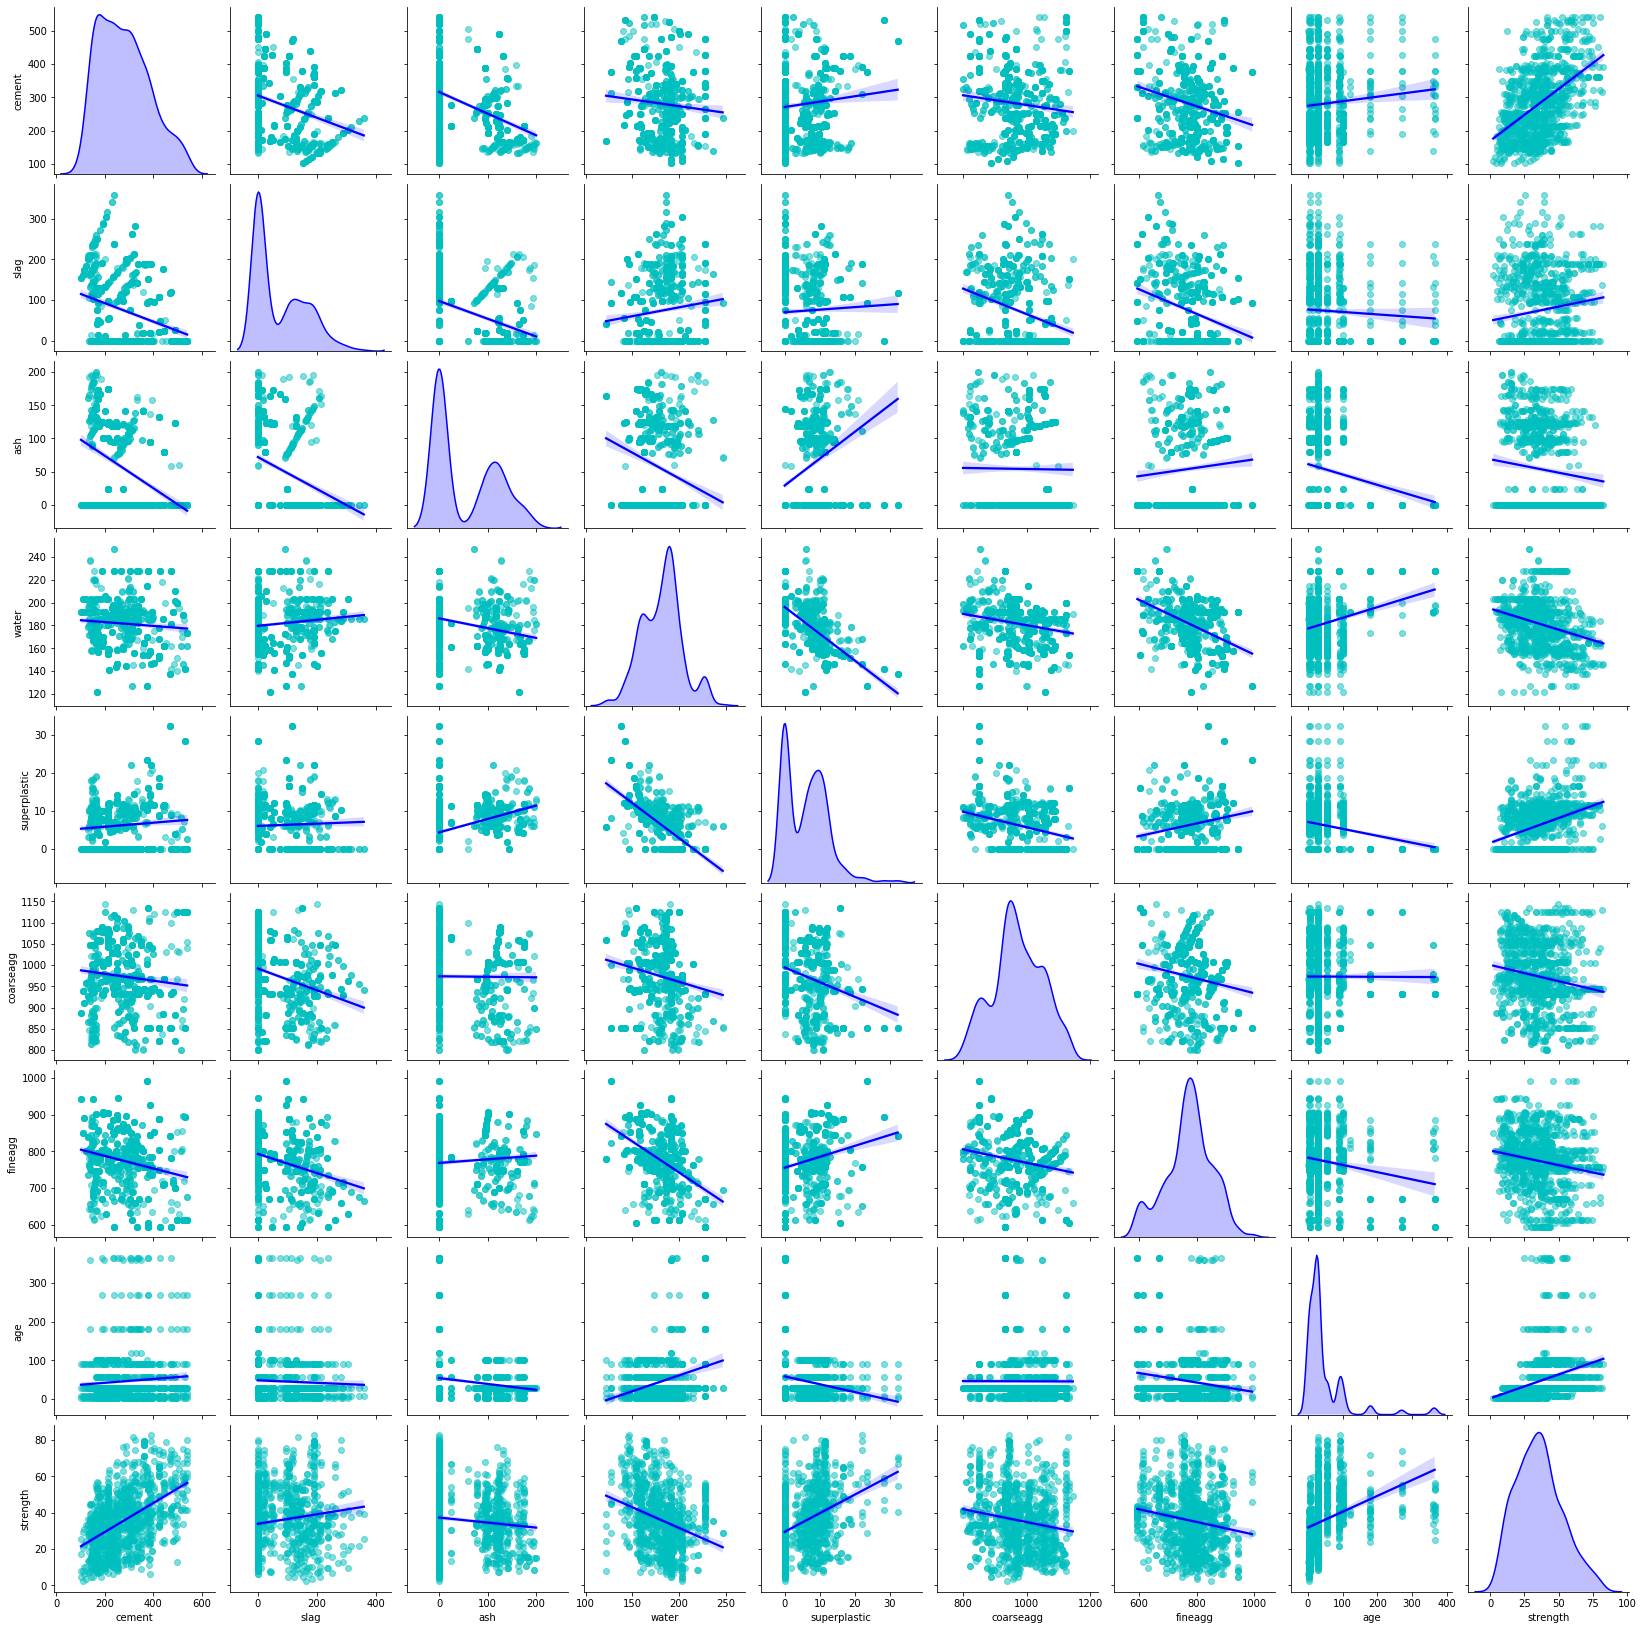

In [57]:
# correlation plots
sns.pairplot(df,
             kind='reg',
             diag_kind="kde",
             plot_kws={'line_kws':{'color':'b'},
                           'scatter_kws': {'alpha': 0.5,
                                           'color': 'c'}},
             diag_kws= {'color': 'b'}
            )

Notes on the bi-variate analysis:
- There is inverse correlation between 'Superplastic' and 'Water'
- There is some correlation between Target ('strength') variable and 'cement','superplastic' and 'age'
- Although not perfect, Target variable seems to have a normal distribution, with some bias to the right, and few outliers, so I would not upscale or downscale.
- There is a mild correlation or no correlation among the rest of the input variables.
- 'age' is very biased to the right, confirms there are outliers
- Distribution of 'cement' is almost normal
- Variables that have two or more gausians and are skewed: 'ash','slag','superplastic' and 'age'
- Slag, coarseagg, fineagg and ash are weak predictors, because they look as a cloud
- Water appears to have a negative correlation with strength and superplastic
- Cement and slag have strong correlation - we can keep only cement

In summary, we need to keep: age, cement, superplastic, water


### Featuring Engineering

Will consist of:

- Droping the less relevant features
- Treating Outliers - Only for 'age', 'water' and 'superplastic' - those variables with more outliers
- Scalation (from box plot some variables are displaced in scale)
- Attempt 2nd or higher degree (order)


We see several features with gauseans, and we need to treat them, referring to the database readme file, it seams that zero values are valid (not missing data), however, looking at the paper where this database was used, it says

In [58]:
df2=df.copy(deep=True)
display(df2['superplastic'].describe())
for i in range(len(df2.superplastic)):
            q1, q2, q3 = df2.superplastic.quantile([0.25,0.5,0.75])
            IQR = q3 - q1
            a = df2.superplastic[i] > q3 + 1.5*IQR
            b = df2.superplastic[i] < q1 - 1.5*IQR
            c = df2.superplastic.mean()
            df2.superplastic[i] = np.where(a | b, c, df2.superplastic[i])

display(df2['superplastic'].describe())

count   1,030.00
mean        6.20
std         5.97
min         0.00
25%         0.00
50%         6.40
75%        10.20
max        32.20
Name: superplastic, dtype: float64

count   1,030.00
mean        5.97
std         5.48
min         0.00
25%         0.00
50%         6.11
75%        10.07
max        23.40
Name: superplastic, dtype: float64

In [59]:
display(df2['age'].describe())
for i in range(len(df2.age)):
            q1, q2, q3 = df2.age.quantile([0.25,0.5,0.75])
            IQR = q3 - q1
            a = df2.age[i] > q3 + 1.5*IQR
            b = df2.age[i] < q1 - 1.5*IQR
            c = df2.age.mean()
            df2.age[i] = np.where(a | b, c, df2.age[i])

display(df2['age'].describe())


count   1,030.00
mean       45.66
std        63.17
min         1.00
25%         7.00
50%        28.00
75%        56.00
max       365.00
Name: age, dtype: float64

count   1,030.00
mean       29.65
std        23.50
min         1.00
25%         7.00
50%        28.00
75%        32.00
max       120.00
Name: age, dtype: float64

In [60]:
display(df2['water'].describe())
for i in range(len(df2.water)):
            q1, q2, q3 = df2.water.quantile([0.25,0.5,0.75])
            IQR = q3 - q1
            a = df2.water[i] > q3 + 1.5*IQR
            b = df2.water[i] < q1 - 1.5*IQR
            c = df2.water.mean()
            df2.water[i] = np.where(a | b, c, df2.water[i])

display(df2['water'].describe())

count   1,030.00
mean      181.57
std        21.35
min       121.80
25%       164.90
50%       185.00
75%       192.00
max       247.00
Name: water, dtype: float64

count   1,030.00
mean      181.62
std        20.60
min       126.60
25%       164.90
50%       185.00
75%       192.00
max       228.00
Name: water, dtype: float64

In [61]:
# Splitting the data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(df2.drop(['ash', 'coarseagg', 'fineagg', 'strength'], axis=1), 
                                                   df2['strength'], 
                                                   test_size = 0.2, 
                                                   random_state=33)
scaler = StandardScaler().fit( X_train)
X_train_scaled = scaler.transform( X_train) 

### Creating the model and tuning it

#### Will create several algorithms and compare results:
- Linear regresion (with and without using pipelines)
- Ridge
- Lasso
- Decision Tree
- Random Forest
- AdaBoost
- Gradient Boosting
- KNN

In [62]:
# Importing additional libraries
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
#####################################################################

# First, use the Linear Regression: 
mod=LinearRegression()
mod.fit( X_train_scaled, y_train)
X_test_scaled = scaler.transform( X_test) 
TrS=("{:.2f}".format( mod.score( X_train_scaled, y_train)))
TsS=("{:.2f}".format( mod.score( X_test_scaled, y_test)))
print(" Test score 1: {:.2f}".format( mod.score( X_test_scaled, y_test)))
resultsDf = pd.DataFrame({'Model':['LinearRegression'], 'Train_Score': TrS,'Test_Score': TsS})
#resultsDf = resultsDf[['Model', 'Train_Score', 'Test_Score']]

# Using Linear Regression but in a pipieline:
####################
pipe = Pipeline([(" sclr", StandardScaler()), (" mod", LinearRegression())])
pipe.fit( X_train, y_train)
print(" Test score P {:.2f}". format( pipe.score( X_test, y_test)))
TrS=("{:.2f}".format( pipe.score( X_train, y_train)))
TsS=("{:.2f}".format( pipe.score( X_test, y_test)))
tempResultsDf = pd.DataFrame({'Model':['LinearRegression Pipe'], 'Train_Score': TrS,'Test_Score': TsS})
resultsDf = pd.concat([resultsDf, tempResultsDf])

# Using Linear Regression degree=3 (cubic) and Cross-Validation from here on.
# (also tried quadratic and there was some improvement over simple Linear Regression, but lower than cubic)
####################
pipe2 = Pipeline([(" sclr", StandardScaler()),
                  ('poly_features', PolynomialFeatures(degree=3)),
                  ('Linear Regression degree 2', LinearRegression()
                  )])
scorTr = cross_val_score(pipe2, X_train, y_train, cv=10, scoring='r2')
print(scor)
print("Accuracy: %0.2f (+/- %0.2f)" % (scorTr.mean(), scorTr.std() * 2))

# updating Results Dataframe:
pipe2.fit( X_train, y_train)
TrS=("{:.2f}".format( pipe2.score( X_train, y_train)))
TsS=("{:.2f}".format( scorTr.mean()))
tempResultsDf = pd.DataFrame({'Model':['LinearRegression Degree=3'], 'Train_Score': TrS,'Test_Score': TsS})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf

 Test score 1: 0.65
 Test score P 0.65
[0.90080956 0.84609934 0.88063266 0.83355601 0.85072888 0.85198895
 0.86543284 0.84294406 0.81919696 0.85837337]
Accuracy: 0.85 (+/- 0.04)


,Model,Train_Score,Test_Score
0,LinearRegression,0.68,0.65
0,LinearRegression Pipe,0.68,0.65
0,LinearRegression Degree=3,0.88,0.85


The degree= 3 does improve the results, so I will keep using it.

In [63]:
# Using Ridge Regression: 
####################
pipe2 = Pipeline([(" sclr", StandardScaler()),
                  ('poly_features', PolynomialFeatures(degree=3)),
                  ('Ridge degree 3', Ridge(random_state=33)
                  )])
scorTr = cross_val_score(pipe2, X_train, y_train, cv=10, scoring='r2')
print(scor)
print("Accuracy: %0.2f (+/- %0.2f)" % (scorTr.mean(), scorTr.std() * 2))

# updating Results Dataframe:
pipe2.fit( X_train, y_train)
TrS=("{:.2f}".format( pipe2.score( X_train, y_train)))
TsS=("{:.2f}".format( scorTr.mean()))
tempResultsDf = pd.DataFrame({'Model':['Ridge Degree=3'], 'Train_Score': TrS,'Test_Score': TsS})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf

[0.90080956 0.84609934 0.88063266 0.83355601 0.85072888 0.85198895
 0.86543284 0.84294406 0.81919696 0.85837337]
Accuracy: 0.85 (+/- 0.04)


,Model,Train_Score,Test_Score
0,LinearRegression,0.68,0.65
0,LinearRegression Pipe,0.68,0.65
0,LinearRegression Degree=3,0.88,0.85
0,Ridge Degree=3,0.88,0.85


In [64]:
# Using Lasso Regression: 
####################
pipe2 = Pipeline([(" sclr", StandardScaler()),
                  ('poly_features', PolynomialFeatures(degree=3)),
                  ('Lasso degree 3', Lasso(random_state=33)    
                  )])
scorTr = cross_val_score(pipe2, X_train, y_train, cv=10, scoring='r2')
print(scor)
print("Accuracy: %0.2f (+/- %0.2f)" % (scorTr.mean(), scorTr.std() * 2))

# updating Results Dataframe:
pipe2.fit( X_train, y_train)
TrS=("{:.2f}".format( pipe2.score( X_train, y_train)))
TsS=("{:.2f}".format( scorTr.mean()))
tempResultsDf = pd.DataFrame({'Model':['Lasso Degree=3'], 'Train_Score': TrS,'Test_Score': TsS})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf

[0.90080956 0.84609934 0.88063266 0.83355601 0.85072888 0.85198895
 0.86543284 0.84294406 0.81919696 0.85837337]
Accuracy: 0.76 (+/- 0.04)


,Model,Train_Score,Test_Score
0,LinearRegression,0.68,0.65
0,LinearRegression Pipe,0.68,0.65
0,LinearRegression Degree=3,0.88,0.85
0,Ridge Degree=3,0.88,0.85
0,Lasso Degree=3,0.78,0.76


In [65]:
# Using Decision Tree Regression: 
####################
pipe2 = Pipeline([(" sclr", StandardScaler()),
                  ('Decision Tree', DecisionTreeRegressor(random_state=33, max_depth=5)
                  )])
scorTr = cross_val_score(pipe2, X_train, y_train, cv=10, scoring='r2')
print(scor)
print("Accuracy: %0.2f (+/- %0.2f)" % (scorTr.mean(), scorTr.std() * 2))

# updating Results Dataframe:
pipe2.fit( X_train, y_train)
TrS=("{:.2f}".format( pipe2.score( X_train, y_train)))
TsS=("{:.2f}".format( scorTr.mean()))
tempResultsDf = pd.DataFrame({'Model':['Decision Tree'], 'Train_Score': TrS,'Test_Score': TsS})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf

[0.90080956 0.84609934 0.88063266 0.83355601 0.85072888 0.85198895
 0.86543284 0.84294406 0.81919696 0.85837337]
Accuracy: 0.74 (+/- 0.09)


,Model,Train_Score,Test_Score
0,LinearRegression,0.68,0.65
0,LinearRegression Pipe,0.68,0.65
0,LinearRegression Degree=3,0.88,0.85
0,Ridge Degree=3,0.88,0.85
0,Lasso Degree=3,0.78,0.76
0,Decision Tree,0.81,0.74


In [66]:
# Using AdaBoost Regression: 
####################
pipe2 = Pipeline([(" sclr", StandardScaler()),
                  ('AdaBoost', AdaBoostRegressor(random_state=42)
                  )])
scorTr = cross_val_score(pipe2, X_train, y_train, cv=10, scoring='r2')
print(scor)
print("Accuracy: %0.2f (+/- %0.2f)" % (scorTr.mean(), scorTr.std() * 2))

# updating Results Dataframe:
pipe2.fit( X_train, y_train)
TrS=("{:.2f}".format( pipe2.score( X_train, y_train)))
TsS=("{:.2f}".format( scorTr.mean()))
tempResultsDf = pd.DataFrame({'Model':['AdaBoost'], 'Train_Score': TrS,'Test_Score': TsS})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf

[0.90080956 0.84609934 0.88063266 0.83355601 0.85072888 0.85198895
 0.86543284 0.84294406 0.81919696 0.85837337]
Accuracy: 0.79 (+/- 0.05)


,Model,Train_Score,Test_Score
0,LinearRegression,0.68,0.65
0,LinearRegression Pipe,0.68,0.65
0,LinearRegression Degree=3,0.88,0.85
0,Ridge Degree=3,0.88,0.85
0,Lasso Degree=3,0.78,0.76
0,Decision Tree,0.81,0.74
0,AdaBoost,0.81,0.79


In [67]:
# Using Random Forest Regression: 
####################
pipe2 = Pipeline([(" sclr", StandardScaler()),
                  ('Random Forest', RandomForestRegressor(random_state=42, max_depth=4)
                  )])
scorTr = cross_val_score(pipe2, X_train, y_train, cv=10, scoring='r2')
print(scor)
print("Accuracy: %0.2f (+/- %0.2f)" % (scorTr.mean(), scorTr.std() * 2))

# updating Results Dataframe:
pipe2.fit( X_train, y_train)
TrS=("{:.2f}".format( pipe2.score( X_train, y_train)))
TsS=("{:.2f}".format( scorTr.mean()))
tempResultsDf = pd.DataFrame({'Model':['Random Forest'], 'Train_Score': TrS,'Test_Score': TsS})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf

[0.90080956 0.84609934 0.88063266 0.83355601 0.85072888 0.85198895
 0.86543284 0.84294406 0.81919696 0.85837337]
Accuracy: 0.77 (+/- 0.07)


,Model,Train_Score,Test_Score
0,LinearRegression,0.68,0.65
0,LinearRegression Pipe,0.68,0.65
0,LinearRegression Degree=3,0.88,0.85
0,Ridge Degree=3,0.88,0.85
0,Lasso Degree=3,0.78,0.76
0,Decision Tree,0.81,0.74
0,AdaBoost,0.81,0.79
0,Random Forest,0.81,0.77


In [68]:
# Using Gradient Boosting Regression: 
####################
pipe2 = Pipeline([(" sclr", StandardScaler()),
                  ('Gradient Boostin', GradientBoostingRegressor(random_state=42, max_depth=4)
                  )])
scorTr = cross_val_score(pipe2, X_train, y_train, cv=10, scoring='r2')
print(scor)
print("Accuracy: %0.2f (+/- %0.2f)" % (scorTr.mean(), scorTr.std() * 2))

# updating Results Dataframe:
pipe2.fit( X_train, y_train)
TrS=("{:.2f}".format( pipe2.score( X_train, y_train)))
TsS=("{:.2f}".format( scorTr.mean()))
tempResultsDf = pd.DataFrame({'Model':['Gradient Boosting'], 'Train_Score': TrS,'Test_Score': TsS})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf

[0.90080956 0.84609934 0.88063266 0.83355601 0.85072888 0.85198895
 0.86543284 0.84294406 0.81919696 0.85837337]
Accuracy: 0.91 (+/- 0.05)


,Model,Train_Score,Test_Score
0,LinearRegression,0.68,0.65
0,LinearRegression Pipe,0.68,0.65
0,LinearRegression Degree=3,0.88,0.85
0,Ridge Degree=3,0.88,0.85
0,Lasso Degree=3,0.78,0.76
0,Decision Tree,0.81,0.74
0,AdaBoost,0.81,0.79
0,Random Forest,0.81,0.77
0,Gradient Boosting,0.97,0.91


In [69]:
# Using KNN Regression: 
####################
pipe2 = Pipeline([(" sclr", StandardScaler()),
                  ('KNN', KNeighborsRegressor(n_neighbors=3)
                  )])
scorTr = cross_val_score(pipe2, X_train, y_train, cv=10, scoring='r2')
print(scor)
print("Accuracy: %0.2f (+/- %0.2f)" % (scorTr.mean(), scorTr.std() * 2))

# updating Results Dataframe:
pipe2.fit( X_train, y_train)
TrS=("{:.2f}".format( pipe2.score( X_train, y_train)))
TsS=("{:.2f}".format( scorTr.mean()))
tempResultsDf = pd.DataFrame({'Model':['KNN'], 'Train_Score': TrS,'Test_Score': TsS})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf

[0.90080956 0.84609934 0.88063266 0.83355601 0.85072888 0.85198895
 0.86543284 0.84294406 0.81919696 0.85837337]
Accuracy: 0.82 (+/- 0.05)


,Model,Train_Score,Test_Score
0,LinearRegression,0.68,0.65
0,LinearRegression Pipe,0.68,0.65
0,LinearRegression Degree=3,0.88,0.85
0,Ridge Degree=3,0.88,0.85
0,Lasso Degree=3,0.78,0.76
0,Decision Tree,0.81,0.74
0,AdaBoost,0.81,0.79
0,Random Forest,0.81,0.77
0,Gradient Boosting,0.97,0.91
0,KNN,0.93,0.82


Seems that the best model is Gradient Boosting
I ran the models also without outlier treatment, and the score was .90, there is a small improvement to 0.91 after treaing the outliers.

#### Hyper parameter tuning

The best result was obtained with Gradient Boosting for this Concrete prediction objective, and Score of 80-95% was obtained (90%), so I chose this algorithm for tunning.  I will split data (75-25) into training and testing sets
Will use training data to perform cross validation - hyper parameter tuning (using Grid Search)


In [70]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(df2.drop(['ash', 'coarseagg', 'fineagg', 'strength'], axis=1), 
                                                   df['strength'], 
                                                   test_size = 0.25, 
                                                   random_state=33)
# Parameter grid
param_grid = {
    'criterion': ['mse', 'mae', 'friedman_mse'], 
    'learning_rate': [0.05, 0.1, 0.15, 0.2], 
    'max_depth': [2, 3, 4, 5], 
    'max_features': ['sqrt', None], 
    'max_leaf_nodes': list(range(2, 10)),
    'n_estimators': list(range(50, 200, 50)),
    'subsample': [0.8, 0.9, 1.0]
}
# Use GridSearchCV to tune the model
from sklearn.model_selection import RandomizedSearchCV
ranSe = RandomizedSearchCV(estimator=GradientBoostingRegressor(random_state=33), param_distributions=param_grid, 
                 return_train_score= True, n_jobs=-1, verbose=2, cv = 10, n_iter=200)
ranSe.fit(X_train, y_train)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1013 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1458 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1985 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  8.2min finished


RandomizedSearchCV(cv=10, estimator=GradientBoostingRegressor(random_state=33),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'criterion': ['mse', 'mae',
                                                      'friedman_mse'],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2],
                                        'max_depth': [2, 3, 4, 5],
                                        'max_features': ['sqrt', None],
                                        'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8,
                                                           9],
                                        'n_estimators': [50, 100, 150],
                                        'subsample': [0.8, 0.9, 1.0]},
                   return_train_score=True, verbose=2)

In [71]:
ranSe_mean = ranSe.best_score_
std = ranSe.cv_results_['mean_test_score'].std()

print(f"Mean training score: {ranSe.cv_results_['mean_train_score'].mean()}")
print(f"Mean validation score: {ranSe_mean}")
print(f"Validation standard deviation: {std}")
print(f"95% confidence interval: {str(round(ranSe_mean-(1.96*std),3)) + ' <-> ' + str(round(ranSe_mean+(1.96*std),3))}")
print(f"Best parameters: {ranSe.best_params_}")
print(f"Test score: {ranSe.score(X_test, y_test)}")

Mean training score: 0.8949554467395595
Mean validation score: 0.9286179385736528
Validation standard deviation: 0.06324166058497513
95% confidence interval: 0.805 <-> 1.053
Best parameters: {'subsample': 0.9, 'n_estimators': 150, 'max_leaf_nodes': 9, 'max_features': 'sqrt', 'max_depth': 4, 'learning_rate': 0.2, 'criterion': 'mse'}
Test score: 0.9162724017010468


In [72]:
d=ranSe.best_score_
e=ranSe.cv_results_['mean_train_score'].mean()
f=ranSe.score(X_test, y_test)

tempResultsDf = pd.DataFrame({'Model':['Gradient Boosting Tuned'], 'Train_Score': e,'Test_Score': f})
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf

,Model,Train_Score,Test_Score
0,LinearRegression,0.68,0.65
0,LinearRegression Pipe,0.68,0.65
0,LinearRegression Degree=3,0.88,0.85
0,Ridge Degree=3,0.88,0.85
0,Lasso Degree=3,0.78,0.76
0,Decision Tree,0.81,0.74
0,AdaBoost,0.81,0.79
0,Random Forest,0.81,0.77
0,Gradient Boosting,0.97,0.91
0,KNN,0.93,0.82


Score is optimal at 200 estimators (I tried also 100, 300 and 500 with lower results)

In [73]:
# Repeat for the second model requested :    (I picked KNN)
# Parameter grid
X_train, X_test, y_train, y_test = train_test_split(df2.drop(['ash', 'coarseagg', 'fineagg', 'strength'], axis=1), 
                                                   df['strength'], 
                                                   test_size = 0.25, 
                                                   random_state=33)
params = {'n_neighbors':[5,6,7,8,9],
          'leaf_size':[1,2,3,4],
          'weights':['uniform', 'distance'],
          'algorithm':['auto', 'ball_tree','kd_tree','brute'],
          'n_jobs':[-1]}

from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
#from sklearn import linear_model
ranSe = RandomizedSearchCV(estimator=KNeighborsRegressor(), param_distributions=params, 
                 return_train_score= True, n_jobs=-1, verbose=2, cv = 10, n_iter=200)
ranSe.fit(X_train, y_train)

#================
ranSe_mean = ranSe.best_score_
std = ranSe.cv_results_['mean_test_score'].std()

print(f"Mean training score: {ranSe.cv_results_['mean_train_score'].mean()}")
print(f"Mean validation score: {ranSe_mean}")
print(f"Validation standard deviation: {std}")
print(f"95% confidence interval: {str(round(ranSe_mean-(1.96*std),3)) + ' <-> ' + str(round(ranSe_mean+(1.96*std),3))}")
print(f"Best parameters: {ranSe.best_params_}")
print(f"Test score: {ranSe.score(X_test, y_test)}")
#================
d=ranSe.best_score_
e=ranSe.cv_results_['mean_train_score'].mean()
f=ranSe.score(X_test, y_test)

tempResultsDf = pd.DataFrame({'Model':['KNN Tuned'], 'Train_Score': e,'Test_Score': f})

Fitting 10 folds for each of 160 candidates, totalling 1600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.4s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1600 out of 1600 | elapsed:  1.7min finished


Mean training score: 0.9039408101041531
Mean validation score: 0.7995344528057504
Validation standard deviation: 0.03875778319533099
95% confidence interval: 0.724 <-> 0.875
Best parameters: {'weights': 'distance', 'n_neighbors': 5, 'n_jobs': -1, 'leaf_size': 1, 'algorithm': 'brute'}
Test score: 0.8077424066691615


#### Final reults report:  

In [74]:
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf

,Model,Train_Score,Test_Score
0,LinearRegression,0.68,0.65
0,LinearRegression Pipe,0.68,0.65
0,LinearRegression Degree=3,0.88,0.85
0,Ridge Degree=3,0.88,0.85
0,Lasso Degree=3,0.78,0.76
0,Decision Tree,0.81,0.74
0,AdaBoost,0.81,0.79
0,Random Forest,0.81,0.77
0,Gradient Boosting,0.97,0.91
0,KNN,0.93,0.82


## Conclusions

Outlier treatment, quadratic degree algorithms and scaling work together to improve the results, however, tunnig is as powerfull or more, in this case there was only a slight improvement with the Tuning, with similar legnth of coding to get better results. although computational time is expensive (aprox. 8 to 50 minutes) as opposed to almost immediate result with the pipeline version.  KNN tuning mean result was almost the same, but marginally lower. For this particular case I found Gradient Boosting to be the best fit for the Concrete strength prediction, and it CAN predict with good confidence of 95%.  However, in the future I will compare most model types and select the best one, before spending a lot of computational time in tunning, because some models did poorly (0.77) as compared to the best (0.92).

Refferences:
(1).- 2016, Regression models for compressive strength of concrete under different curing conditions Kolawole Adisa Olonade, Heni Fitriani and Olutobi Toluwalase Kola
